In [11]:
import os
if "py" not in os.listdir("."):
    os.chdir("..")
    
%config Completer.use_jedi = False

In [12]:
import microdf as mdf
import numpy as np
import openfisca_uk as o
import pandas as pd
from openfisca_uk import IndividualSim, PopulationSim
from openfisca_uk.reforms.modelling import reported_benefits
from py.calc_ubi import ubi_reform

REGION_CODES = [
    "NORTH_EAST",
    "NORTH_WEST",
    "YORKSHIRE",
    "EAST_MIDLANDS",
    "WEST_MIDLANDS",
    "EAST_OF_ENGLAND",
    "LONDON",
    "SOUTH_EAST",
    "SOUTH_WEST",
    "WALES",
    "SCOTLAND",
    "NORTHERN_IRELAND",
]

REGION_NAMES = [
    "North East",
    "North West",
    "Yorkshire and the Humber",
    "East Midlands",
    "West Midlands",
    "East of England",
    "London",
    "South East",
    "South West",
    "Wales",
    "Scotland",
    "Northern Ireland",
]

region_code_map = dict(zip(range(len(REGION_CODES)), REGION_CODES))
region_name_map = dict(zip(range(len(REGION_NAMES)), REGION_NAMES))

optimal_params = pd.read_csv("optimal_params.csv")  # Up a folder.


def reform(i):
    row = optimal_params.iloc[i].round()
    return ubi_reform(
        adult=row.adult,
        child=row.child,
        senior=row.senior,
        dis_base=row.dis_base,
        geo=row[REGION_CODES],
    )


reforms = [reform(i) for i in range(3)]

baseline_sim = PopulationSim(reported_benefits)
reform_sims = [PopulationSim(reported_benefits, reform) for reform in reforms]

REFORM_NAMES = ["1: Foundational", "2: Disability", "3: Disability + geo"]

BASELINE_PERSON_COLS = [
    "household_weight",
    "age",
    "region",
    "is_disabled_for_ubi",
]

# Extract these for baseline too.
REFORM_PERSON_COLS = [
    "household_net_income",
    "in_poverty_bhc",
    "in_deep_poverty_bhc",
]

BASELINE_HH_COLS = ["household_weight", "people_in_household", "region"]

# Extract these for baseline too.
REFORM_HH_COLS = [
    "household_net_income",
    "equiv_household_net_income",
    "poverty_gap_bhc",
    "poverty_gap_ahc",
]

p_base = mdf.MicroDataFrame(
    baseline_sim.df(
        BASELINE_PERSON_COLS + REFORM_PERSON_COLS, map_to="person"
    ),
    weights="household_weight",
)
p_base.rename(
    dict(zip(REFORM_PERSON_COLS, [i + "_base" for i in REFORM_PERSON_COLS])),
    axis=1,
    inplace=True,
)

hh_base = mdf.MicroDataFrame(
    baseline_sim.df(BASELINE_HH_COLS + REFORM_HH_COLS, map_to="household"),
    weights="household_weight",
)
hh_base.rename(
    dict(zip(REFORM_HH_COLS, [i + "_base" for i in REFORM_HH_COLS])),
    axis=1,
    inplace=True,
)
hh_base["person_weight"] = (
    hh_base.household_weight * hh_base.people_in_household
)

# # Add region code and names
# hh_base["region_code"] = hh_base.region.map(region_code_map)
# hh_base["region_name"] = hh_base.region.map(region_name_map)
# p_base["region_code"] = p_base.region.map(region_code_map)
# p_base["region_name"] = p_base.region.map(region_name_map)

# Change weight column to represent people for decile groups.
hh_base.set_weights(hh_base.person_weight)
hh_base["decile"] = np.ceil(
    hh_base.equiv_household_net_income_base.rank(pct=True) * 10
)

# Change weight back to household weight for correct calculation of totals.
hh_base.set_weights(hh_base.household_weight)


def reform_p(i):
    p = reform_sims[i].df(REFORM_PERSON_COLS, map_to="person")
    p["reform"] = REFORM_NAMES[i]
    return mdf.concat([p_base, p], axis=1)


def reform_hh(i):
    hh = reform_sims[i].df(REFORM_HH_COLS, map_to="household")
    hh["reform"] = REFORM_NAMES[i]
    return mdf.concat([hh_base, hh], axis=1)


def pct_chg(base, new):
    return (new - base) / base


def reform_stats(df):
    # For applying over a groupby(reform) or a .
    gini = df.equiv_household_net_income_base.aggregate(
        ["gini", "top_10pct_share"]
    )
    p_agg = df[["household_net_income_pl", "winner"]].mean()



p = mdf.concat([reform_p(i) for i in range(3)])
h = mdf.concat([reform_hh(i) for i in range(3)])

p = p.reset_index(drop=True)#.drop("index", axis=1)
h = h.reset_index(drop=True)#.drop("index", axis=1)

def chg(df, col):
    df[col + "_chg"] = df[col] - df[col + "_base"]
    # Percentage change, only defined for positive baselines.
    df[col + "_pc"] = np.where(
        df[col + "_base"] > 0,
        df[col + "_chg"] / df[col + "_base"],
        np.nan,
    )
    # Percentage loss. NB: np.minimum(np.nan, 0) -> np.nan.
    df[col + "_pl"] = np.minimum(0, df[col + "_pc"])

chg(p, "household_net_income")
chg(h, "household_net_income")
p["winner"] = p.household_net_income_chg > 0
h["winner"] = h.household_net_income_chg > 0
# Per-reform.
INEQS = ["gini", "top_10_pct_share", "top_1_pct_share"]
ineq_base = h.groupby("reform").equiv_household_net_income_base.agg(INEQS)
ineq_base.columns = [i + "_base" for i in ineq_base.columns]
ineq_reform = h.groupby("reform").equiv_household_net_income.agg(INEQS)
ineq_reform.columns = [i + "_reform" for i in ineq_reform.columns]
p_agg = p.groupby("reform")[["household_net_income_pl", "winner"]].mean()
r = p_agg.join(ineq_base).join(ineq_reform, on="reform")
r["reform"] = r.index  # Easier for plotting.
for i in INEQS:
    r[i + "_pc"] = pct_chg(r[i + "_base"], r[i + "_reform"])

# Per reform per decile (by household).

decile = (
    h.groupby(["reform", "decile"])
    .sum()[
        [
            "household_net_income",
            "household_net_income_base",
            "people_in_household",
        ]
    ]
    .reset_index()
)
decile["chg"] = (
    decile.household_net_income - decile.household_net_income_base
)
decile["chg_pp"] = decile.chg / decile.people_in_household
decile["pc"] = decile.chg / decile.household_net_income_base
# return p, h, r, decile

In [60]:
BUCKETS = ["Lose more than 5%", "Lose less than 5%", "Gain less than 5%", "Gain more than 5%"]
h["household_net_income_pc_group"] = pd.cut(h.household_net_income_pc, [-np.inf, -0.05, 0, 0.05, np.inf],
                                            labels=BUCKETS)

In [73]:
def group(groupby, name="people_in_household"):
    return (
        h[h.household_net_income_base > 0].groupby(groupby)
        .people_in_household.sum()
        .reset_index()
        .rename({0: name}, axis=1)
    )


chg_bucket = group(["reform", "decile", "household_net_income_pc_group"])
chg_bucket_decile_total = group(["reform", "decile"], "total_people_in_household")
chg_bucket_total = group(["reform", "household_net_income_pc_group"])
reform_total = group("reform")
# Calculate share of decile.
chg_bucket = chg_bucket.merge(chg_bucket_decile_total, on=["reform", "decile"])
chg_bucket["share_of_decile"] = chg_bucket.people_in_household / chg_bucket.total_people_in_household

# Sort for correct stack order.
chg_bucket["order"] = chg_bucket.household_net_income_pc_group.map(dict(zip(BUCKETS, range(len(BUCKETS)))))
chg_bucket.sort_values("order", ascending=False, inplace=True)
chg_bucket

,reform,decile,household_net_income_pc_group,people_in_household,total_people_in_household,share_of_decile,order
119,3: Disability + geo,10.0,Gain more than 5%,551368.0,6556995.0,0.084089,3
23,1: Foundational,6.0,Gain more than 5%,1762852.0,6552148.0,0.269049,3
31,1: Foundational,8.0,Gain more than 5%,1490442.0,6548129.0,0.227613,3
111,3: Disability + geo,8.0,Gain more than 5%,1552945.0,6548129.0,0.237159,3
35,1: Foundational,9.0,Gain more than 5%,1492258.0,6541254.0,0.228130,3
...,...,...,...,...,...,...,...
72,2: Disability,9.0,Lose more than 5%,3176819.0,6541254.0,0.485659,0
76,2: Disability,10.0,Lose more than 5%,4151604.0,6556995.0,0.633156,0
80,3: Disability + geo,1.0,Lose more than 5%,109156.0,5366167.0,0.020342,0
84,3: Disability + geo,2.0,Lose more than 5%,955766.0,6549727.0,0.145925,0


In [79]:
chg_bucket1 = chg_bucket[chg_bucket.reform == "1: Foundational"]
WITHIN_COLORS = [
    "#c56000",  # Medium amber.
    "#ffc046",  # Light amber.
    "#63a4ff",  # Light blue.
    "#004ba0",  # Dark blue.
]
WITHIN_COLOR_MAP = dict(zip(BUCKETS, WITHIN_COLORS))

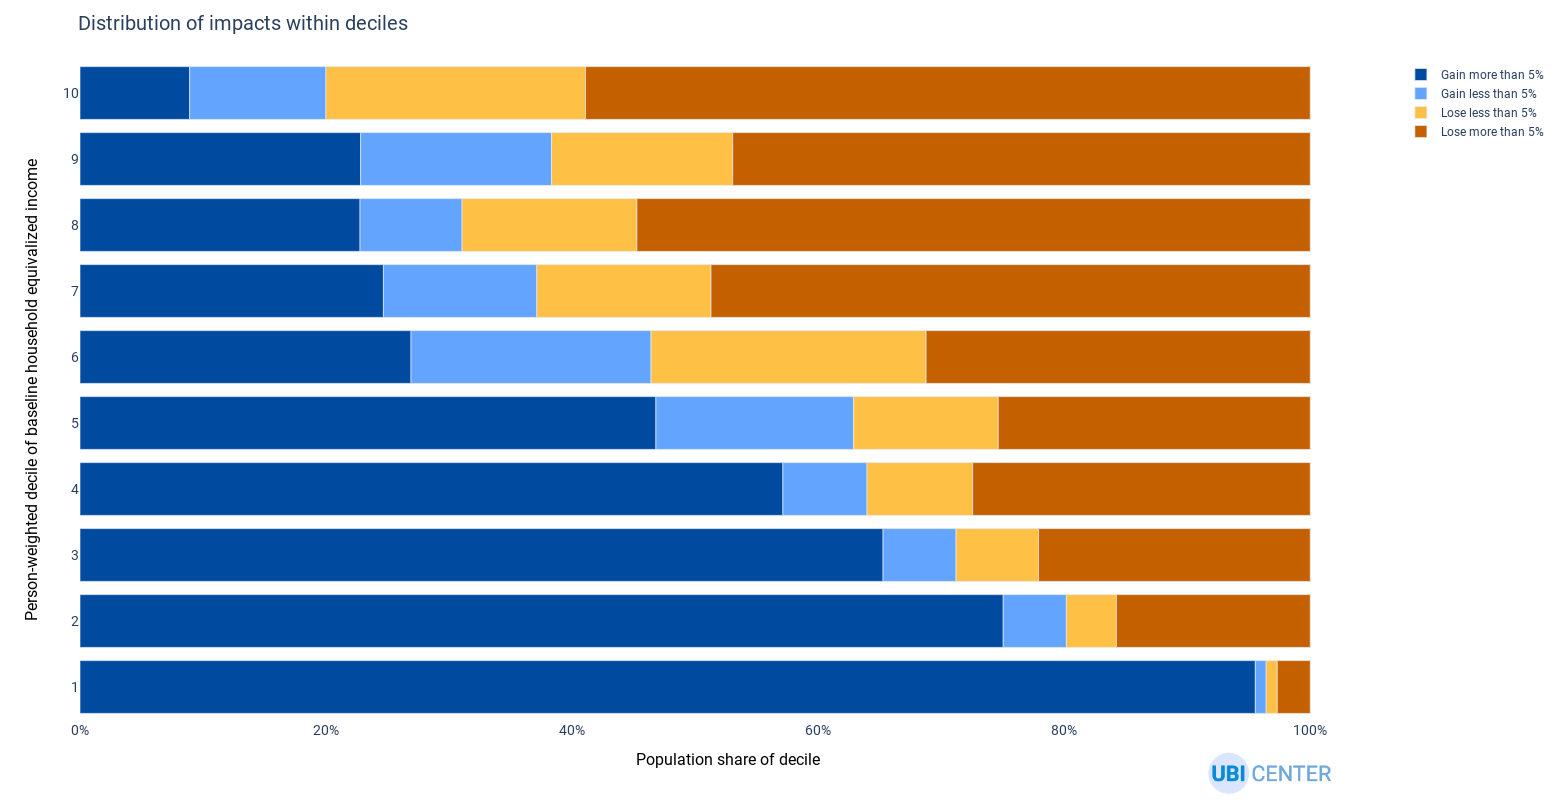

In [86]:
import plotly.express as px
fig = px.bar(chg_bucket1, "share_of_decile", "decile", color="household_net_income_pc_group", orientation="h", color_discrete_map=WITHIN_COLOR_MAP)
fig.update_layout(title="Distribution of impacts within deciles", yaxis_dtick=1, legend_title="", xaxis_tickformat="%", xaxis_title="Population share of decile", yaxis_title="Person-weighted decile of baseline household equivalized income")
import ubicenter
def ubi_chart(fig, name):
    fig = ubicenter.format_fig(fig, show=False)
    fig.write_image(f"images/{name}.png", scale=2)
    ubicenter.format_fig(fig)
ubi_chart(fig, "dist1")

In [5]:
h.reset_index().drop("index", axis=1).__class__

microdf.generic.MicroDataFrame

In [6]:
h.groupby("reform").equiv_household_net_income_base.mean()

reform
1: Foundational        34792.426049
2: Disability          34792.426049
3: Disability + geo    34792.426049
dtype: float64

In [7]:
h[["people_in_household"]].sum()

people_in_household    196435665.0
dtype: float64

In [8]:
h.groupby("decile").sum()

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
h.reform.rank()

In [ ]:
d = mdf.MicroDataFrame({"x": [1, 2, 3]}, index=[1, 1, 2], weights=pd.Series([4, 5, 6], index=[1, 1, 2]))

In [ ]:
d.gini()

In [ ]:
h = h.reset_index().drop("index", axis=1)

In [ ]:
h.index

In [ ]:
h[h.household_net_income_base > 0][["reform", "decile", "household_net_income_base", "household_net_income", "household_weight"]].groupby("reform").sum()

In [ ]:
h[h.household_net_income_base > 0][["reform", "decile", "household_net_income_base", "household_net_income", "household_weight"]].groupby(["reform", "decile"]).sum()

In [ ]:
decile = (
        # Remove non-positive income, for whom income change is unhelpful.
        h[h.household_net_income_base > 0]
        .groupby(["reform", "decile"])[
            [
                "household_net_income_base",
                "household_net_income",
                "household_weight",
            ]
        ]
        .sum()
        .reset_index()
    )
decile["chg"] = (
    decile.household_net_income - decile.household_net_income_base
)
decile["chg_per_hh"] = decile.chg / decile.household_weight
decile["pc"] = decile.chg / decile.household_net_income_base

In [ ]:
pd.DataFrame(hh_base).groupby("decile").person_weight.sum()

In [ ]:
hh_base.equiv_household_net_income_base < (295 * 52)

In [ ]:
((hh_base.equiv_household_net_income_base < (295 * 52)) != hh_base.in_poverty_bhc).mean()

In [ ]:
(hh_base.equiv_household_net_income_base < hh_base.poverty_line_bhc) != hh_base.in_poverty_bhc

In [ ]:
o.tools.aggregates.poverty_rate(baseline_sim)